## 1. Settings

## 1.1 Setting up the environment

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
import numpy as np
import h5py
import matplotlib.pyplot as plt

from tbmalt import Geometry, OrbitalInfo
from tbmalt.ml.module import Calculator
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.io.dataset import DataSetIM
from tbmalt.physics.dftb.properties import dos
import tbmalt.common.maths as tb_math
from tbmalt.common.batch import pack
from tbmalt.data.units import energy_units, length_units
from tbmalt.ml.loss_function import Loss, hellinger_loss

Tensor = torch.Tensor

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

## 1.2 Setting up the silicon system for training

In [27]:
# Provide the training size for reading systems from hdf5 dataset
training_size = 1

# Provide information about the orbitals on each atom; this is keyed by atomic
# numbers and valued by azimuthal quantum numbers like so:
#   {Z₁: [ℓᵢ, ℓⱼ, ..., ℓₙ], Z₂: [ℓᵢ, ℓⱼ, ..., ℓₙ], ...}
shell_dict = {14: [0, 1, 2]}

# Identify which species are present
species = torch.tensor([14])
# Strip out padding species and convert to a standard list.
species = species[species != 0].tolist()

## 1.3 Setting up the model for training

In [28]:
# Location at which the DFTB parameter set database is located
parameter_db_path = './siband.hdf5'

# Type of ML model
model = 'spline'

# Should fitting be performed here?
fit_model = True

# Number of fitting cycles, number of batch size each cycle
number_of_epochs = 200
n_batch = 1

# learning rate
lr = 0.000005

# Type of loss function
loss_func = hellinger_loss

# Location of a file storing the properties that will be fit to.
target_path = './dataset_dos.h5'

# Choose which training and testing dataset to be loaded
target_run = 'run2'

# Energy window for dos sampling
points = torch.linspace(-3.3, 1.6, 491)

## 1.4 Setting up the DFTB calculator

## 1.4.1 Loading of the DFTB parameters into their associated feed objects

In [29]:
# Load the Hamiltonian feed model
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline)

# Load the overlap feed model
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline,)

# Load the occupation feed object
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)

# Load the Hubbard-U feed object
u_feed = HubbardFeed.from_database(parameter_db_path, species)

## 1.4.2 Constructing the SCC-DFTB calculator

In [30]:
mix_params = {'mix_param': 0.2, 'init_mix_param': 0.2,
              'generations': 3, 'tolerance': 1e-10}
kwargs = {}
kwargs['mix_params'] = mix_params
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, supress_SCF_error=True,
                        filling_temp=None, **kwargs)

## 2. Data preparation

## 2.1 Load the dataset

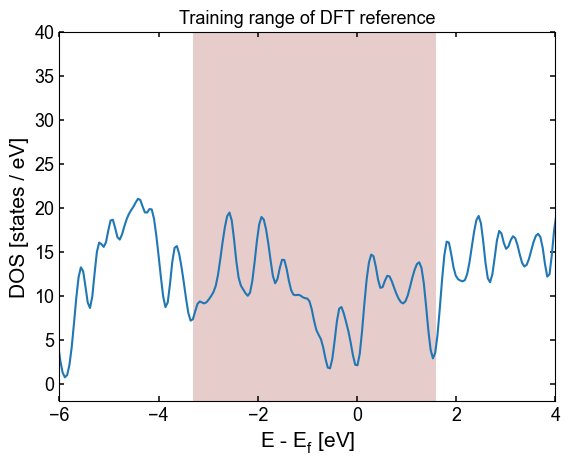

In [31]:
# Define a function to load data from hdf5 dataset
def load_target_data(path: str, group1: str, group2: str, properties: List,
                     size: int) -> Any:
    """Load fitting target data.

    Arguments:
        path: path to a database in which the fitting data can be found.
        group 1: string to select the training run.
        group 2: string to select training or testing data.
        properties: list to select properties.
        size: size to load data.

    Returns:
        targets: returns an <OBJECT> storing the data to which the model is to
            be fitted.
    """
    # Data could be loaded from a json file or an hdf5 file; use your own
    # discretion here. A dictionary might be the best object in which to store
    # the target data.

    # To adjust the new Geometry
    with h5py.File(path, 'a') as f:
        for igroup1 in ['run1', 'run2', 'run3', 'run_transfer']:
            for igroup2 in ['train', 'test']:
                if 'lattice_vector' not in f[igroup1][igroup2].keys():
                    f[igroup1][igroup2]['lattice_vector'] = f[igroup1][igroup2]['cells']

    # To adjust the new dataloader
    with h5py.File(path, 'a') as f:
        attrs = f[group1][group2].attrs
        labels = attrs.get('labels', attrs.get('label', None))
        if labels is not None:
            attrs.__delitem__('label')

    return DataSetIM.load_data_batch(path, group1 + '/' + group2, properties,
                                     pbc=True)

# Load traing data
dataloder_train = load_target_data(target_path, target_run, 'train', ['homo_lumos', 'eigenvalues'], training_size)
indice = torch.arange(training_size).tolist()
data_train = dataloder_train[indice[: training_size]]
numbers_train, positions_train, cells_train = (data_train.geometry.atomic_numbers,
                                               data_train.geometry.positions,
                                               data_train.geometry.lattice)
ref_ev, ref_hl = (data_train.data['eigenvalues'], data_train.data['homo_lumos'])
targets = {'eigenvalues': ref_ev,
           'homo_lumos': ref_hl}

# Plot the training area of the system
energies_plot = torch.linspace(-18, 5, 500).repeat(training_size, 1)
dos_plot = dos((ref_ev), energies_plot, 0.09)
dos_plot_mean = dos_plot.mean(dim=0)
fermi_train_plot = targets['homo_lumos'].mean(dim=-1)
energies_train_plot = fermi_train_plot.unsqueeze(-1) + points.unsqueeze(0).repeat_interleave(training_size, 0)
plt.plot(energies_plot[0] - fermi_train_plot.mean(dim=0), dos_plot_mean,
         linewidth=1.5, color='tab:blue')
plt.fill_between(energies_train_plot.mean(dim=0) - fermi_train_plot.mean(dim=0),
                 -3, 60, alpha=0.2, facecolor='darkred')
plt.xlim(-6, 4)
plt.ylim(-2, 40)
plt.tick_params(direction='in', labelsize='13', width=1.1, top='on',
                right='on')
plt.rcParams["font.family"] = "arial"
plt.xlabel(r'E - $\mathregular{E_f}$ [eV]', fontsize=15)
plt.ylabel('DOS [states / eV]', fontsize=15)
plt.title("Training range of DFT reference", fontsize=13)
plt.show()

## 2.2 Input the molecular systems

In [32]:
# Construct the `Geometry` and `OrbitalInfo` objects.
geometry = Geometry(numbers_train, positions_train, cells_train, units='a',
                    cutoff=torch.tensor([18.0])/length_units['angstrom'])
orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict, shell_resolved=False)

## 2.3 Build delegates

In [33]:
# Define a delegate to obtain predictions from the trained model
def prediction_delegate(calculator, targets, **kwargs):
    predictions = dict()
    fermi_dftb = calculator.homo_lumo.mean(dim=-1) / energy_units['ev']
    energies_dftb = fermi_dftb.unsqueeze(-1) + points.unsqueeze(0).repeat_interleave(n_batch, 0)
    dos_dftb = dos(calculator.eigenvalue / energy_units['ev'], energies_dftb, 0.09)
    predictions["dos"] = dos_dftb
    
    return predictions

In [34]:
# Define a delegate to obtain reference results
def reference_delegate(calculator, targets, **kwargs):
    reference = dict()
    ref_ev = targets["eigenvalues"]
    fermi_train = targets['homo_lumos'].mean(dim=-1)
    energies_train = fermi_train.unsqueeze(-1) + points.unsqueeze(0).repeat_interleave(training_size, 0)
    dos_ref = dos((ref_ev), energies_train, 0.09)
    reference["dos"] = dos_ref
    
    return reference

## 3. Model training

In [35]:
# Define parameters to optimize
for key in h_feed._off_sites.keys():
    # Collect spline parameters and add to optimizer
    h_feed._off_sites[key].coefficients.requires_grad_(True)
    s_feed._off_sites[key].coefficients.requires_grad_(True)

if model == 'spline':
    h_var = [val.coefficients for key, val in h_feed._off_sites.items()]
    s_var = [val.coefficients for key, val in s_feed._off_sites.items()]
    variable = h_var + s_var

In [36]:
# Define the loss entity
loss_entity = Loss(prediction_delegate, reference_delegate,
                   loss_functions=loss_func, reduction='sum')

In [37]:
# Define optimizer
optimizer = getattr(torch.optim, 'Adam')(params=variable, lr=lr)

In [38]:
# Execution
loss_list = []
loss_list.append(0)
for epoch in range(number_of_epochs):
    _loss = 0
    print('epoch', epoch)
    dftb_calculator(geometry, orbs)
    total_loss, raw_losses = loss_entity(dftb_calculator, targets)
    _loss = _loss + total_loss
    optimizer.zero_grad()
    _loss.retain_grad()

    # Invoke the autograd engine
    _loss.backward(retain_graph=True)

    # Update the model
    optimizer.step()
    print("loss:", _loss)
    loss_list.append(_loss.detach())

epoch 0
loss: tensor(12.3409, grad_fn=<AddBackward0>)
epoch 1
loss: tensor(12.2181, grad_fn=<AddBackward0>)
epoch 2
loss: tensor(12.0964, grad_fn=<AddBackward0>)
epoch 3
loss: tensor(11.9760, grad_fn=<AddBackward0>)
epoch 4
loss: tensor(11.8570, grad_fn=<AddBackward0>)
epoch 5
loss: tensor(11.7397, grad_fn=<AddBackward0>)
epoch 6
loss: tensor(11.6240, grad_fn=<AddBackward0>)
epoch 7
loss: tensor(11.5101, grad_fn=<AddBackward0>)
epoch 8
loss: tensor(11.3978, grad_fn=<AddBackward0>)
epoch 9
loss: tensor(11.2874, grad_fn=<AddBackward0>)
epoch 10
loss: tensor(11.1786, grad_fn=<AddBackward0>)
epoch 11
loss: tensor(11.0716, grad_fn=<AddBackward0>)
epoch 12
loss: tensor(10.9662, grad_fn=<AddBackward0>)
epoch 13
loss: tensor(10.8623, grad_fn=<AddBackward0>)
epoch 14
loss: tensor(10.7598, grad_fn=<AddBackward0>)
epoch 15
loss: tensor(10.6587, grad_fn=<AddBackward0>)
epoch 16
loss: tensor(10.5588, grad_fn=<AddBackward0>)
epoch 17
loss: tensor(10.4603, grad_fn=<AddBackward0>)
epoch 18
loss: tenso

## 4. Plotting

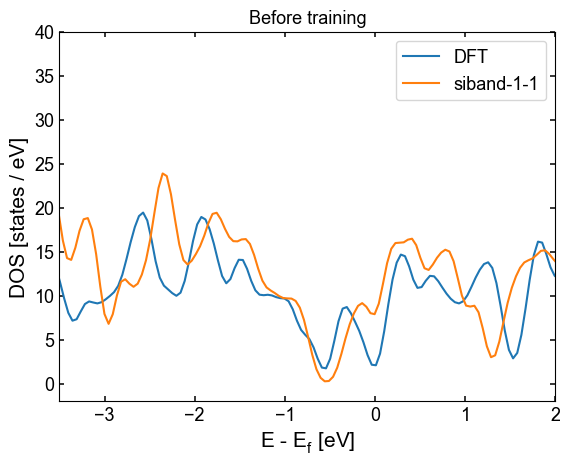

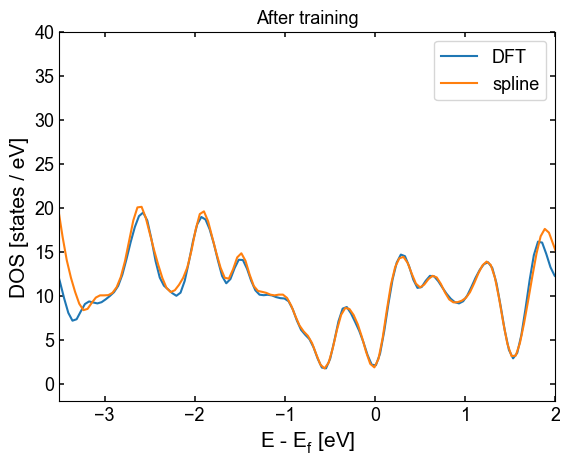

In [39]:
# Reference DOS for plotting
ref_hl_plot = targets['homo_lumos']
ref_ev_plot = targets["eigenvalues"]
ref_fermi_plot = targets['homo_lumos'].mean(dim=-1)
ref_energies_plot = torch.linspace(-18.0, 5.0, 500)
ref_dos_plot = dos((ref_ev_plot), ref_energies_plot, 0.09)

# Original DFTB calculations
h_feed_o = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                                        interpolation=CubicSpline)
s_feed_o = SkFeed.from_database(parameter_db_path, species, 'overlap',
                                interpolation=CubicSpline)
mix_params = {'mix_param': 0.2, 'init_mix_param': 0.2,
              'generations': 3, 'tolerance': 1e-10}
kwargs = {}
kwargs['mix_params'] = mix_params
dftb_calculator_o = Dftb2(h_feed_o, s_feed_o, o_feed, u_feed, filling_temp=None, **kwargs)
dftb_calculator_o(geometry, orbs)

hl_dftb = getattr(dftb_calculator_o, 'homo_lumo').detach() / energy_units['ev']
fermi_dftb = hl_dftb.mean(-1)
eigval_dftb = getattr(dftb_calculator_o, 'eigenvalue').detach() / energy_units['ev']
dos_dftb = dos((eigval_dftb), ref_energies_plot, 0.09)

# Results brfore training
plt.plot((ref_energies_plot - ref_fermi_plot).squeeze(0), ref_dos_plot.squeeze(0), label='DFT')
plt.plot((ref_energies_plot - fermi_dftb).squeeze(0), dos_dftb.squeeze(0), label='siband-1-1')
plt.xlim(-3.5, 2)
plt.ylim(-2, 40)
plt.tick_params(direction='in', labelsize='13', width=1.1, top='on', right='on')
plt.rcParams["font.family"] = "arial"
plt.xlabel(r'E - $\mathregular{E_f}$ [eV]', fontsize=15)
plt.ylabel('DOS [states / eV]', fontsize=15)
plt.title("Before training", fontsize=13)
plt.legend(fontsize=13)
plt.show()

# Prediction after training
hl_pred = getattr(dftb_calculator, 'homo_lumo').detach() / energy_units['ev']
fermi_pred = hl_pred.mean(-1)
eigval_pred = getattr(dftb_calculator, 'eigenvalue').detach() / energy_units['ev']
dos_pred = dos((eigval_pred), ref_energies_plot, 0.09)
plt.plot((ref_energies_plot - ref_fermi_plot).squeeze(0), ref_dos_plot.squeeze(0), label='DFT')
plt.plot((ref_energies_plot - fermi_pred).squeeze(0), dos_pred.squeeze(0), label='spline')
plt.xlim(-3.5, 2)
plt.ylim(-2, 40)
plt.tick_params(direction='in', labelsize='13', width=1.1, top='on',
                right='on')
plt.rcParams["font.family"] = "arial"
plt.xlabel(r'E - $\mathregular{E_f}$ [eV]', fontsize=15)
plt.ylabel('DOS [states / eV]', fontsize=15)
plt.title("After training", fontsize=13)
plt.legend(fontsize=13)
plt.show()